# Employee Attrition

In [112]:
import helper
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from tempfile import mkdtemp
from sklearn.base import clone
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE, SelectFromModel
from sklearn.metrics import accuracy_score as metric_scorer
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, KBinsDiscretizer, PowerTransformer, OneHotEncoder, FunctionTransformer

warnings.filterwarnings(action='once')

### Setting Key Values

The following values are used throught the code, this cell gives a central source where they can be managed

In [93]:
MEMORY = mkdtemp()

KEYS = {
    'SEED': 1,
    'DATA_PATH' : 'https://gist.githubusercontent.com/akoury/d5943d9c3dba8dc20a4c0c35027b110c/raw/8f01edb1ce950511cab5f9aa6aafd14bd2fe96db/Turnover',
    'TARGET': 'left',
    'METRIC': 'accuracy',
    'TIMESERIES': False,
    'SPLITS': 5,
    'ESTIMATORS': 150,
    'ITERATIONS': 500,
    'MEMORY': MEMORY
}

hp = helper.Helper(KEYS)

### Data Loading

Here we load the necessary data, print its first rows and describe its contents

In [3]:
def read_data(input_path):
    return pd.read_csv(input_path)

data = read_data(KEYS['DATA_PATH'])

data.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [4]:
data.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


### Data types

We review the data types for each column

In [5]:
data.dtypes

satisfaction_level       float64
last_evaluation          float64
number_project             int64
average_montly_hours       int64
time_spend_company         int64
Work_accident              int64
left                       int64
promotion_last_5years      int64
sales                     object
salary                    object
dtype: object

### Missing Data

We check if there is any missing data

In [6]:
hp.missing_data(data)

,Total,Percent
salary,0,0.0
sales,0,0.0
promotion_last_5years,0,0.0
left,0,0.0
Work_accident,0,0.0
time_spend_company,0,0.0
average_montly_hours,0,0.0
number_project,0,0.0
last_evaluation,0,0.0
satisfaction_level,0,0.0


### Converting columns to their true categorical type
Now we convert the data types of numerical columns that are actually categorical

In [7]:
data = hp.convert_to_category(data, data.iloc[:,5:8])

data.dtypes

satisfaction_level        float64
last_evaluation           float64
number_project              int64
average_montly_hours        int64
time_spend_company          int64
Work_accident            category
left                     category
promotion_last_5years    category
sales                      object
salary                     object
dtype: object

### Defining Holdout Set for Validation

80% of the data will be used to train our model, while the remaining data will be used later on to validate the accuracy of our model

In [13]:
train_data, holdout = train_test_split(data, test_size=0.2)

## Exploratory Data Analysis

Here we will perform all of the necessary data analysis, with different plots that will help us understand the data and therefore, create a better model

We must specify that all of this analysis is performed only on the training data, so that we do not incur in any sort of bias when modeling

We begin by plotting pairwise relationships between variables, as well as the distribution for each column in the diagonal

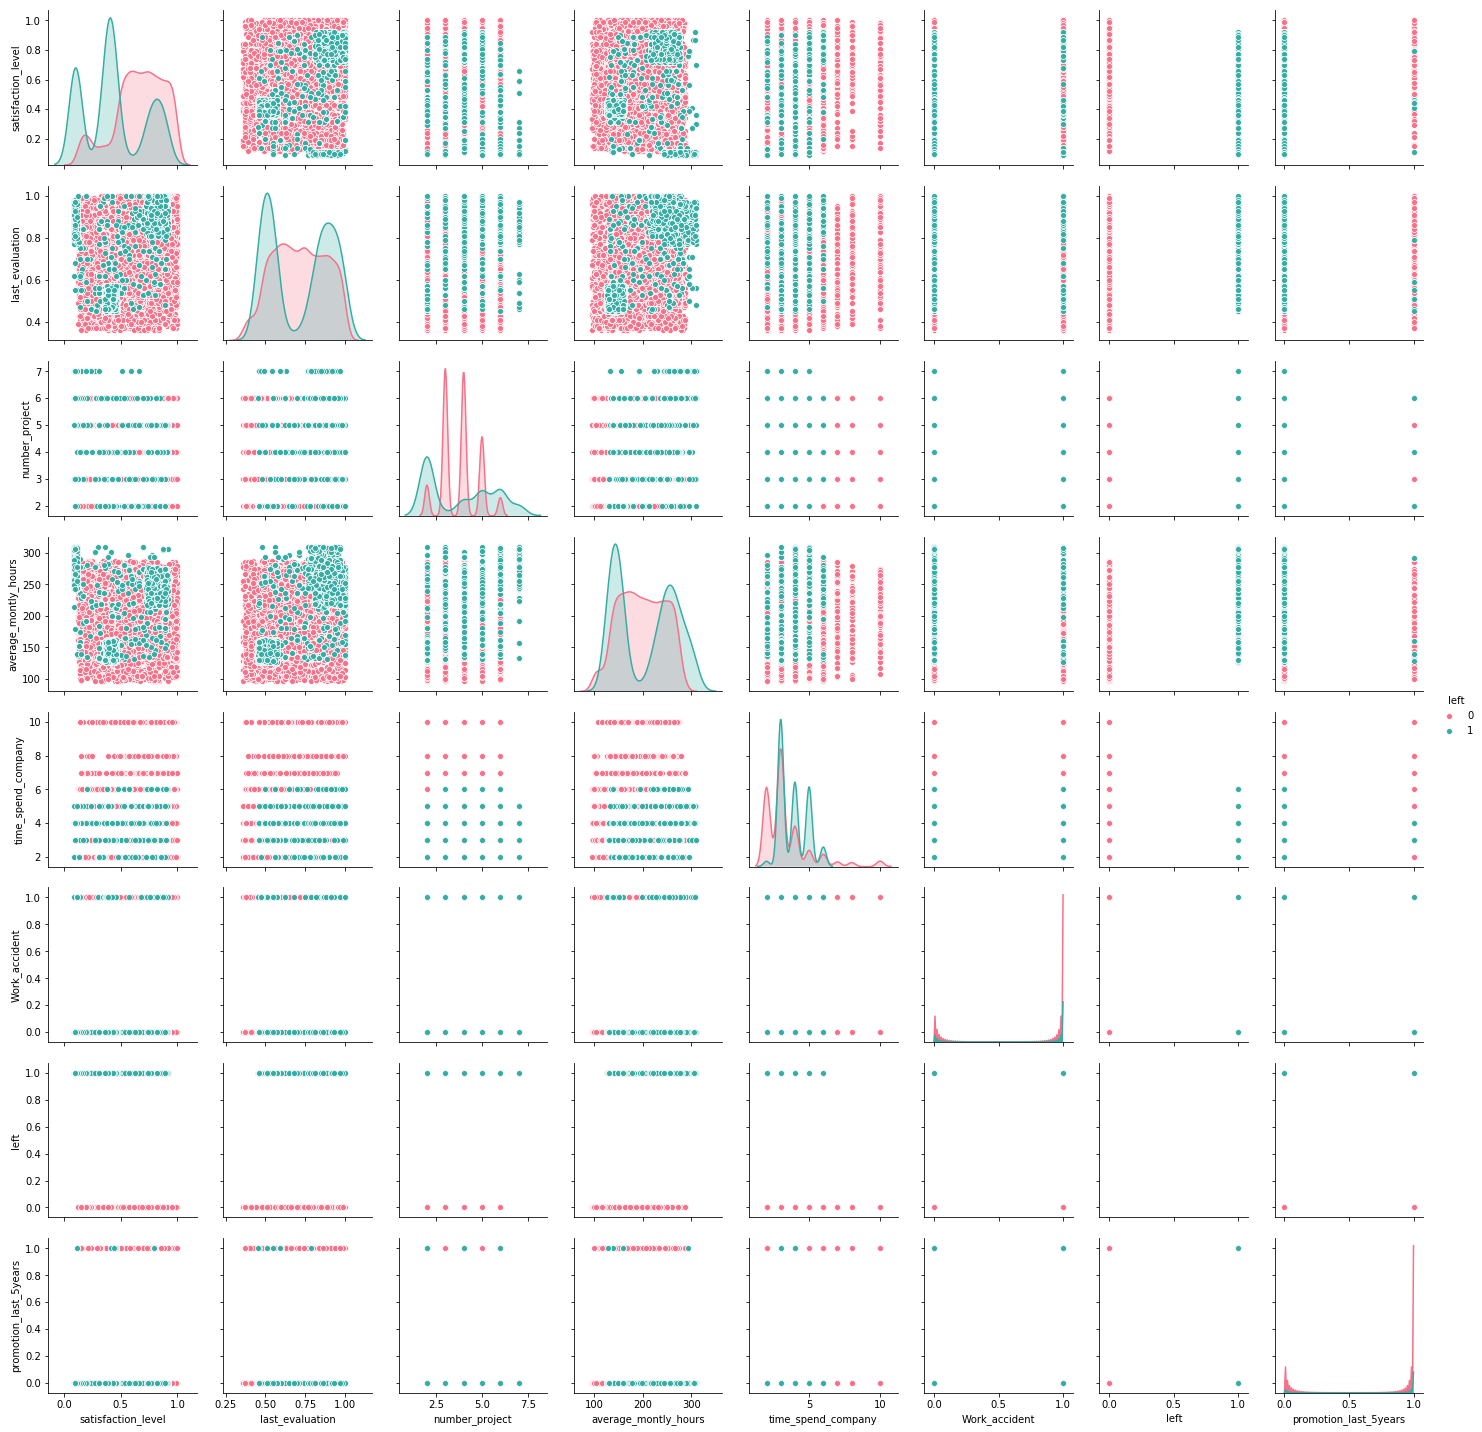

In [14]:
pairplot = sns.pairplot(train_data, hue=KEYS['TARGET'], palette="husl")

### Boxplot of Numerical Variables

We review the distribution of scaled numerical data through a boxplot for each variable

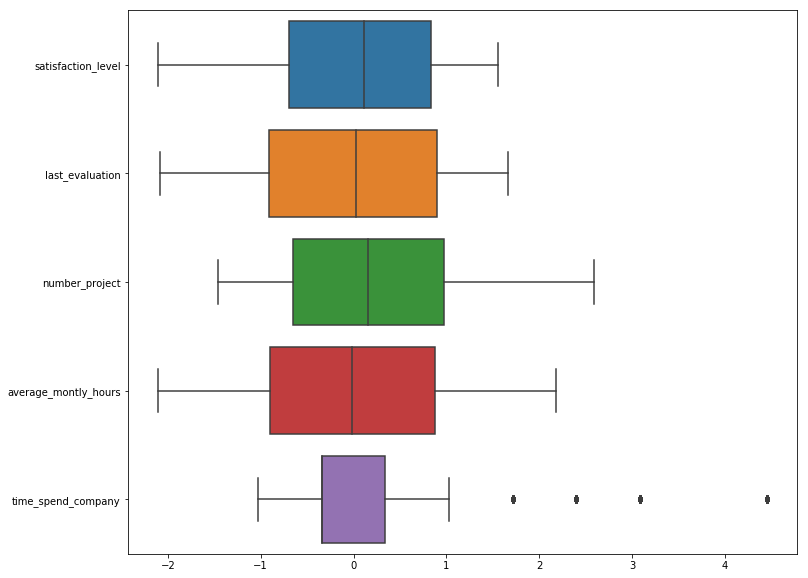

In [15]:
hp.boxplot(data)

### Coefficient of Variation

The coefficient of variation is a dimensionless meassure of dispersion in data, the lower the value the less dispersion a feature has

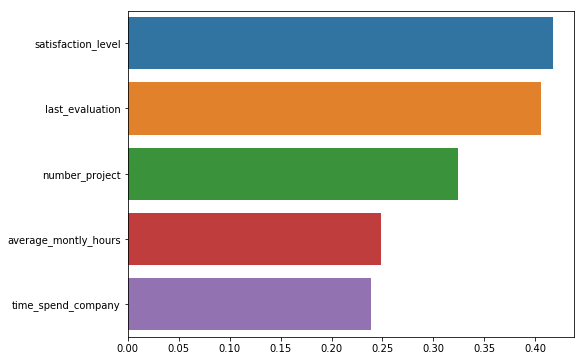

In [16]:
hp.coefficient_v(data)

### Data Correlation

Now we analyze correlation in the data for both numerical and categorical columns and plot them

No correlated columns for the  0.7 threshold


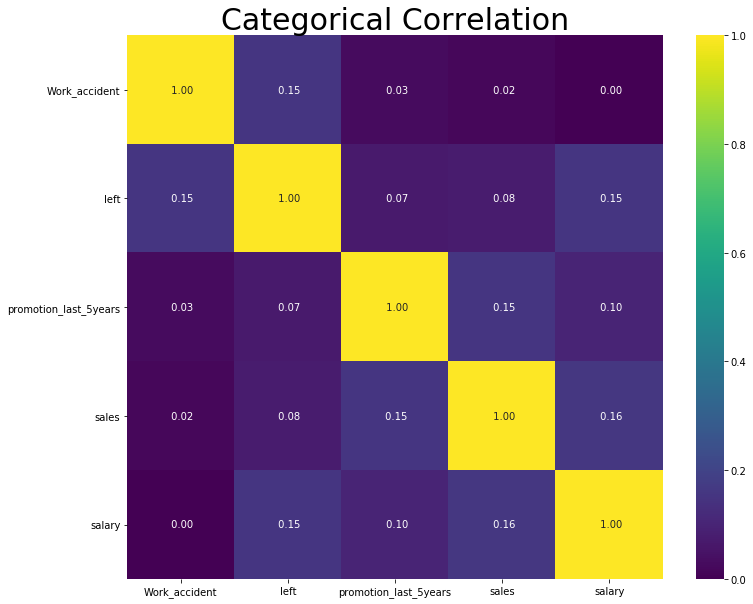

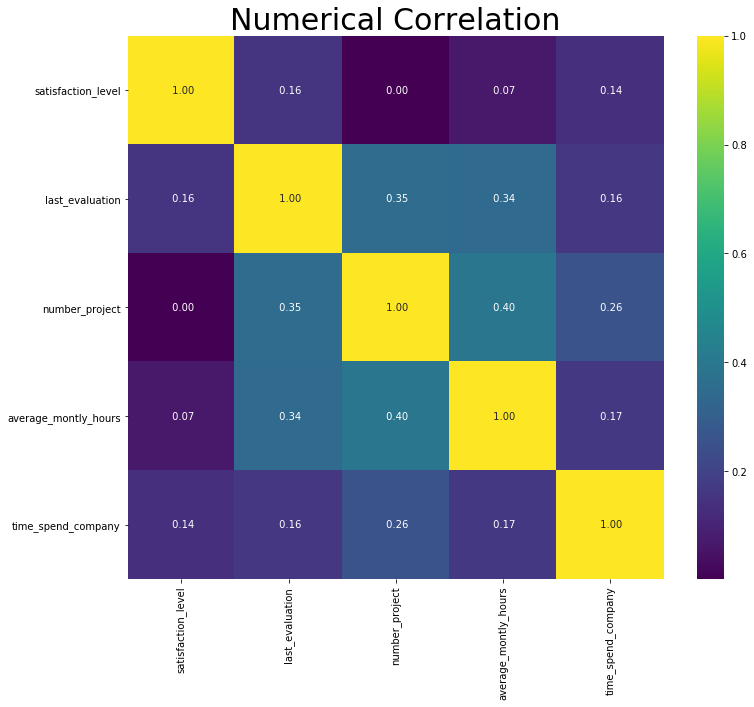

In [17]:
correlated_cols = hp.correlated(train_data, 0.7)

### Underrepresented Features

Now we determine underrepresented features, meaning those that in more than 97% of the records are composed of a single value

In [22]:
under_rep = hp.under_represented(train_data, 0.97)

['promotion_last_5years'] underrepresented


### Principal Component Analysis (PCA)

We plot PCA component variance to define the number of components we wish to consider in the pipeline

In [24]:
# hp.plot_pca_components(data)

### Feature Importance

Here we plot feature importance using a random forest in order to get a sense of which features have the most importance

In [25]:
# hp.feature_importance(data, RandomForestClassifier(n_estimators=KEYS['ESTIMATORS'], random_state = KEYS['SEED']))

### Rebalancing
We review the distribution of values in the target variable

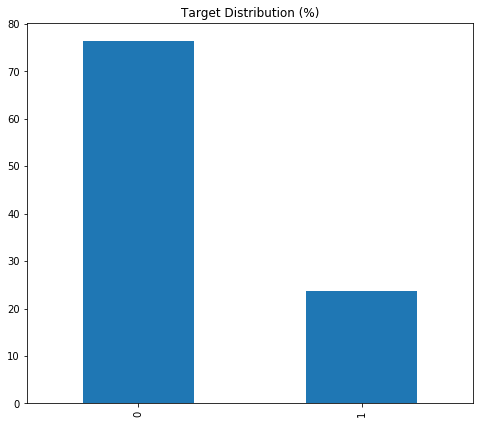

In [45]:
hp.target_distribution(train_data)

And we perform an undersampling of the data

In [47]:
# def rebalance(df):
#     count_class_0, count_class_1 = df[TARGET_VARIABLE].value_counts()

#     df_class_0 = df[df[TARGET_VARIABLE] == 0]
#     df_class_1 = df[df[TARGET_VARIABLE] == 1]
#     df_class_0_under = df_class_0.sample(count_class_1)
    
#     return pd.concat([df_class_0_under, df_class_1], axis=0)

### Outlier Removal

Now we will analyze and remove outliers considering two different methods, winsorizing and through Local Outlier Factor

## Modeling / Pipeline

A number of different combinations of feature engineering steps and transformations will be performed in a pipeline with different models, each one will be cross validated to review the performance of the model

A feature called 'avg_time_per_project' is added to determine the average time each employee spends on a project

In [167]:
def avg_time_pp(df):
    df = df.copy()
    df['avg_time_per_project'] = (df['average_montly_hours'] * 12 * df['time_spend_company'])/ df['number_project']
    df['avg_time_per_project'] = df['avg_time_per_project'].replace([np.inf, -np.inf], np.nan)
    df['avg_time_per_project'] = df['avg_time_per_project'].fillna(0)
    
    return df

def drop_features(df, cols):
    df = avg_time_pp(df)
        
    return df[df.columns.difference(cols)]

num_pipeline = Pipeline([ 
    ('power_transformer', PowerTransformer(method='yeo-johnson', standardize = True)),
#     ('binning', KBinsDiscretizer(n_bins = 5, encode = 'onehot-dense')),
    ('polynomial', PolynomialFeatures(degree = 2, include_bias = False)),
#     ('genetic', SymbolicTransformer(population_size=750, metric='spearman', function_set = ['add', 'sub', 'mul', 'div', 'sqrt', 'log', 'abs', 'neg', 'max', 'min'], parsimony_coefficient = 0.0005, max_samples = 0.9, random_state = KEYS['SEED']))
])

categorical_pipeline = Pipeline([
    ('one_hot', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

pipe = Pipeline([
    ('avg_time_pp', FunctionTransformer(avg_time_pp, validate=False)),
    ('drop_features', FunctionTransformer(drop_features, kw_args={'cols': correlated_cols + under_rep}, validate=False)),
    ('column_transformer', ColumnTransformer([
        ('numerical_pipeline', num_pipeline, hp.numericals(data, [KEYS['TARGET']]).columns),
        ('one_hot_pipeline', categorical_pipeline, ['sales', 'salary']),
    ], remainder='passthrough')),
#     ('rfe', RFE(RandomForestClassifier(n_estimators = KEYS['ESTIMATORS'], random_state = KEYS['SEED']), n_features_to_select = 8)),
#     ('feature_selection', SelectFromModel(RandomForestClassifier(n_estimators = KEYS['ESTIMATORS'], random_state = KEYS['SEED']), threshold = 0.005)),
#     ('pca', PCA(n_components = 6))
])
# ], memory = KEYS['MEMORY'])

models = [
    {'name':'logistic_regression', 'model': LogisticRegression(solver = 'lbfgs', max_iter = KEYS['ITERATIONS'], random_state = KEYS['SEED'])},
    {'name':'random_forest', 'model': RandomForestClassifier(n_estimators = KEYS['ESTIMATORS'], random_state = KEYS['SEED'])},
    {'name': 'extra_tree', 'model': ExtraTreesClassifier(random_state = KEYS['SEED'])}
]

## Scores

Here you can see all of the scores, first with a baseline and then throughout the entire cross validation process for each pipeline, in certain cases errors do happen (for example when a certain fold contains a sparse matrix), therefore you will see errors marked as such in the score

In [169]:
all_scores = hp.pipeline(train_data, models, pipe, note = 'Base model')

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The de

,Model,CV Score,Time,Steps,Note
0,logistic_regression,0.812 +/- 0.008,1.459841,"avg_time_pp, drop_features, power_transformer, one_hot",Base model
1,random_forest,0.989 +/- 0.003,4.461796,"avg_time_pp, drop_features, power_transformer, one_hot",Base model
2,extra_tree,0.984 +/- 0.003,0.599488,"avg_time_pp, drop_features, power_transformer, one_hot",Base model


Here we run the different combinations of pipelines, you may run it multiple times with different parameters and they will be queued`

In [121]:
all_scores = hp.pipeline(train_data, models, pipe, all_scores)

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The de

,Model,CV Score,Time,Steps,Note
0,logistic_regression,0.796 +/- 0.007,0.560747,"power_transformer, one_hot",Base model
1,random_forest,0.989 +/- 0.003,3.992523,"power_transformer, one_hot",Base model
2,extra_tree,0.983 +/- 0.004,0.569651,"power_transformer, one_hot",Base model
3,logistic_regression,0.812 +/- 0.008,1.328386,"drop_features, power_transformer, one_hot",
4,random_forest,0.989 +/- 0.003,4.386961,"drop_features, power_transformer, one_hot",
5,extra_tree,0.984 +/- 0.003,0.739471,"drop_features, power_transformer, one_hot",
6,logistic_regression,0.812 +/- 0.008,1.362581,"avg_time_pp, drop_features, power_transformer, one_hot",
7,random_forest,0.989 +/- 0.003,4.737004,"avg_time_pp, drop_features, power_transformer, one_hot",
8,extra_tree,0.984 +/- 0.003,0.758424,"avg_time_pp, drop_features, power_transformer, one_hot",
9,logistic_regression,0.907 +/- 0.002,1.640185,"avg_time_pp, drop_features, power_transformer, binning, one_hot",


### Pipeline Performance by Model

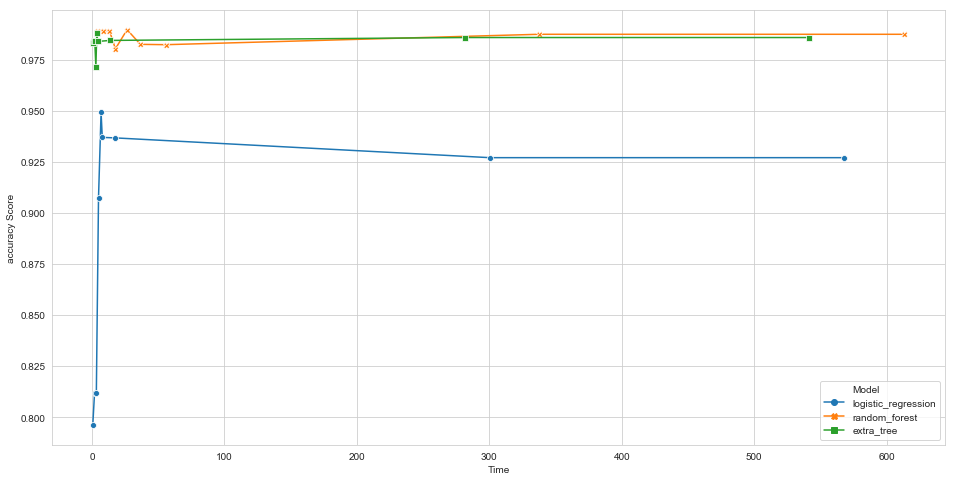

In [122]:
hp.plot_models(all_scores)

## Randomized Grid Search

Once we have a list of models, we perform a cross validated, randomized grid search on the best performing one to define the final model

In [170]:
grid = {
    'random_forest__criterion': ['gini', 'entropy'],
    'random_forest__min_samples_leaf': [10, 20],
    'random_forest__min_samples_split': [5, 8],
    'random_forest__max_leaf_nodes': [30, 60],
}

final_scores, grid_pipe = hp.cv_evaluate(train_data, model = clone(hp.top_pipeline(all_scores)), grid = grid)

### Best Parameters for the Model

In [131]:
print(grid_pipe.best_params_)
final_pipe = grid_pipe.best_estimator_

{'random_forest__min_samples_split': 8, 'random_forest__min_samples_leaf': 10, 'random_forest__max_leaf_nodes': 60, 'random_forest__criterion': 'entropy'}


# Final Score
We evaluate the final model with the holdout, obtaining the definitive score of the model

In [132]:
y, predictions = hp.predict(train_data, holdout, final_pipe)
score = metric_scorer(y, predictions)
score

0.9773333333333334

# Receiver Operating Characteristic (ROC) / Area Under the Curve 
To review the performance of the model, accuracy is not enough, therefore we plot the ROC of the model on the holdout data

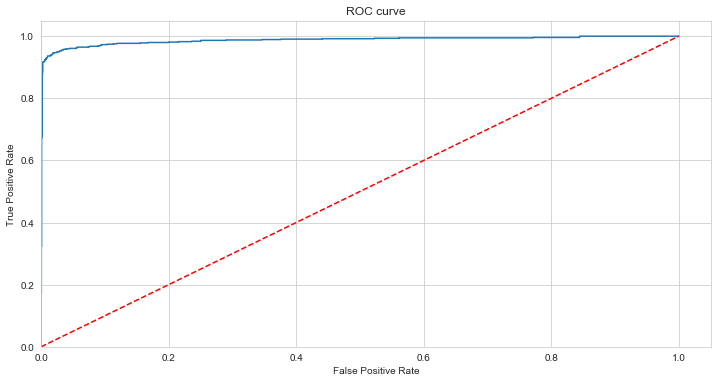

              precision    recall  f1-score   support

           0       0.97      1.00      0.99      2263
           1       0.99      0.92      0.95       737

   micro avg       0.98      0.98      0.98      3000
   macro avg       0.98      0.96      0.97      3000
weighted avg       0.98      0.98      0.98      3000



In [137]:
hp.roc(holdout, final_pipe, predictions)

# Stacked Model
Finally, we create a stacked model using the top 2 models obtained during the modeling phase and obtain the holdout results

In [133]:
stacked, y_stacked, predictions_stacked = hp.stack_predict(train_data, holdout, all_scores, amount = 2)
score_stacked = metric_scorer(y_stacked, predictions_stacked)
score_stacked

0.9896666666666667